In [1]:
import pandas as pd

from scripts.AdjustmentScripts import DataAdj

In [2]:
tpm_meta = pd.read_csv('gtf_genome_file/transcript_length.gtf', sep='\t')

# select top transcript len
tpm_meta = tpm_meta.loc[tpm_meta.groupby('id')['len'].idxmax()]


In [3]:
tpm_meta.head()

,id,len
1,A1BG,8314
2,A1CF,86266
4,A2M,48565
5,A2ML1,64380
6,A3GALT2,14332


In [4]:
adj = DataAdj(tpm_meta)

In [5]:
# Brain - IMR32

d1 = pd.read_csv('data/IMR32.tsv', sep='\t', index_col=0)
d1 = d1.dropna(how='all')
d1 = adj.data_cleaning(d1, fun = 'sum')

In [6]:
# Brest - SKBR3

d2 = pd.read_csv('data/SKBR3.tsv', sep='\t', index_col=0)
d2 = d2.dropna(how='all')
d2 = adj.data_cleaning(d2, fun = 'sum')

In [7]:
# Skin - A431

d3 = pd.read_csv('data/A431.tsv', sep='\t', index_col=0)
d3 = d3.dropna(how='all')
d3 = adj.data_cleaning(d3, fun = 'sum')

In [8]:
# creating full data and metadata file
full_data, metadata = adj.data_concat({'IMR32':d1, 'SKBR3':d2, 'A431': d3})
full_data_TPM = adj.normalize_tpm(full_data)

In [9]:
# exclude mitochondrial genes MT-
filtered_data = full_data_TPM.loc[~full_data_TPM.index.str.contains('MT-', na=False)]

In [10]:
set(filtered_data.index.duplicated())


{False}

In [11]:
# calculation important variable
from scripts.FeaturesSelection import FeaturesSelection

fs = FeaturesSelection(data = filtered_data, metadata = metadata)

fs.fs().head()


,pct_occurrence,mean,variance,p-val,adj_pval,FC,log(FC),set,feature
id,,,,,,,,,
ABCC3,1.000000,3.213638,0.738028,0.0,0.0,3.106929,1.635489,A431,ABCC3
ACCS,0.991228,3.283749,1.183696,0.0,0.0,4.401372,2.137953,A431,ACCS
ACKR3,1.000000,4.295409,4.358865,0.0,0.0,8.044952,3.008084,A431,ACKR3
ACP5,0.973684,3.845149,3.777921,0.0,0.0,4.698479,2.232194,A431,ACP5
ADAM8,0.991228,4.886489,2.842812,0.0,0.0,8.113190,3.020269,A431,ADAM8


In [12]:
top_markers = fs.select_top()

top_markers.head()

,pct_occurrence,mean,variance,p-val,adj_pval,FC,log(FC),set,feature
0,1.0,3.170639,0.349915,0.0,0.0,5.718265,2.515577,A431,IGF2BP2
1,1.0,5.238146,0.564769,0.0,0.0,5.420413,2.438403,A431,LGALS3
2,1.0,4.036214,0.604264,0.0,0.0,5.843520,2.546838,A431,MICA
3,1.0,3.441091,0.625091,0.0,0.0,3.074054,1.620143,A431,PARP12
4,1.0,4.476449,0.628531,0.0,0.0,2.995020,1.582566,A431,PRPS2


In [13]:
filtered_data_markers = filtered_data.loc[list(top_markers['feature']),:]

filtered_data_markers.shape

(150, 470)

In [14]:
# loading requirements for model creating


import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [15]:
# set training (70%) and test (30%) data


X = np.array(filtered_data_markers).T
y = np.array(metadata['names'])

# Split to test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [16]:
# prepare Imputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

# Imputacja danych
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [17]:
# Scale training and test independent
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# prepare example models 
# unbalanced data require class_weight 'balanced'

len(d1.columns) # 136n
len(d2.columns) # 220n
len(d3.columns) # 144n


models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel='linear', class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=200, class_weight='balanced')
}


In [19]:
# evaluate models - get stats

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def ev_mod(models, X_train, X_test, y_train, y_test):
    results = []
    
    for name, model in models.items():
        # train
        model.fit(X_train, y_train)
        
        # predict
        y_pred = model.predict(X_test)
        
        # stats
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
        
    
    results_df = pd.DataFrame(results)
    return results_df


In [20]:
results = ev_mod(models, X_train, X_test, y_train, y_test)
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,SVM,1.000000,1.000000,1.000000,1.000000
2,KNN,0.978723,0.978846,0.978723,0.978693
3,Logistic Regression,1.000000,1.000000,1.000000,1.000000


In [21]:
# evaluate CrossValidation (x) models - get stats

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def evaluate_models_with_cv(models, X_train, y_train):
    results = []
    
    for name, model in models.items():
        # metrices
        scoring = {
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'f1': make_scorer(f1_score, average='weighted')
        }
        
        # cross-validation
        cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
        
        results.append({
            'Model': name,
            'Mean Accuracy': cv_results['test_accuracy'].mean(),
            'Mean Precision': cv_results['test_precision'].mean(),
            'Mean Recall': cv_results['test_recall'].mean(),
            'Mean F1': cv_results['test_f1'].mean(),
        })
        
        
    results_df = pd.DataFrame(results)
    return results_df



In [22]:
cv_results = evaluate_models_with_cv(models, X_train, y_train)  
cv_results.sort_values(by=["Mean Accuracy", "Mean Precision", "Mean Recall", "Mean F1"], ascending=False)

,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1
0,Random Forest,0.993939,0.994186,0.993939,0.993912
1,SVM,0.990909,0.991581,0.990909,0.990970
3,Logistic Regression,0.990909,0.991581,0.990909,0.990970
2,KNN,0.981818,0.982725,0.981818,0.981904


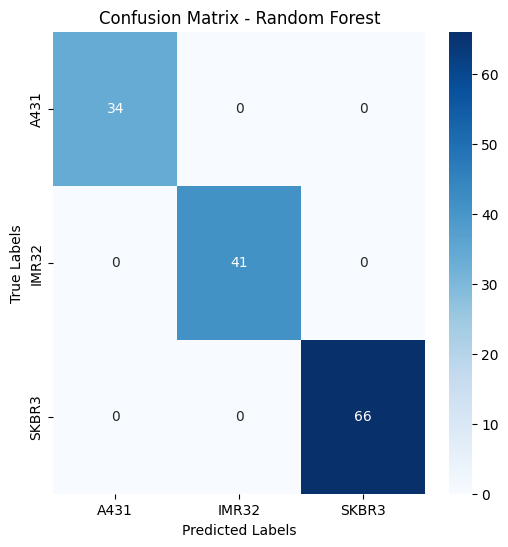

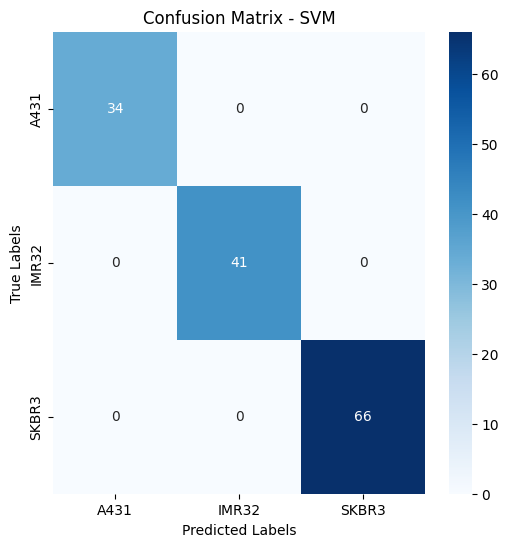

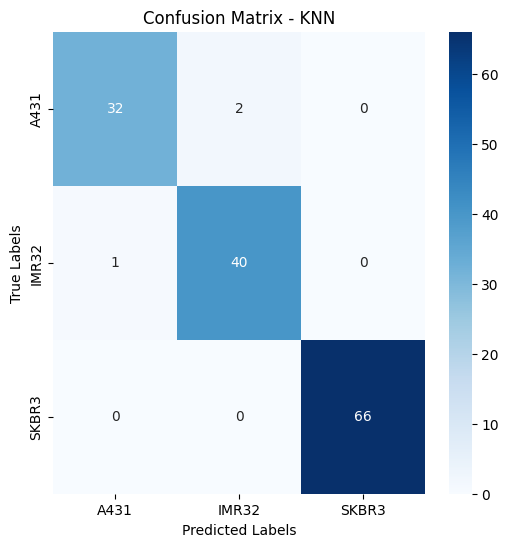

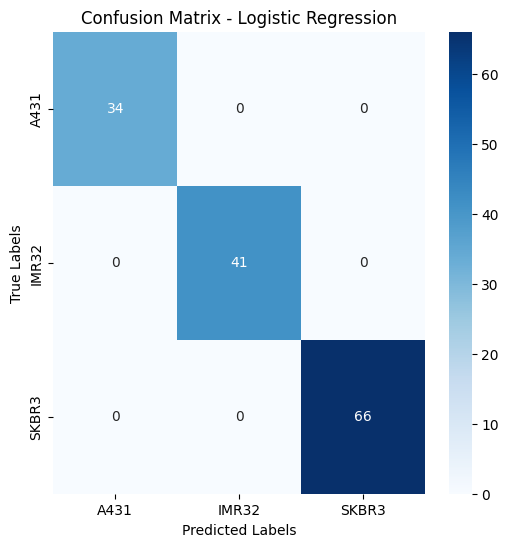

In [23]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


for name, model in models.items():
    plot_confusion_matrix(model, X_test, y_test, name)

In [24]:
# save model
import joblib

from scripts.Model import BestModel

bs = BestModel(name = 'Random Forest',
               model= models['Random Forest'], 
               scaler = scaler, 
               imputer = imputer, 
               features = list(filtered_data_markers.index))
    

joblib.dump(bs, 'BestModel.pkl')

['BestModel.pkl']